## **Home Work 2: Nonlinear Control: Inverse Dynamics, Robust and Adaptive control**

### **Vessel on the River**

Consider a folowing vessel on the river:

<p align="center">
<img src="https://blog.arduino.cc/wp-content/uploads/2021/11/DawveRf-1024x683.jpeg" alt="drawing" width="35%" style="margin:auto"/>
</p>




With differential kinematics described as follows:
$$
\dot{\mathbf{x}} =
\begin{bmatrix}
\dot{x}
\\
\dot{y}
\\
\dot{\theta}
\end{bmatrix}
=
\begin{bmatrix}
 \cos \theta & -\sin \theta & 0\\
 \sin \theta & \cos \theta & 0\\
 0 & 0 & 1\\
\end{bmatrix}
\begin{bmatrix}
v_\tau
\\
v_n
\\
\omega
\end{bmatrix} 
+
\begin{bmatrix}
\delta \\
0 \\
0\\
\end{bmatrix}
= \mathbf{R}(\theta)\mathbf{u} + \boldsymbol{\delta}(t)
$$

where $x, y$ are cartesian coordinates w.r.t global frame, $\theta$ heading angle, $0<\delta<\delta_{max}$ river flow $v_\tau, v_n, \omega$ are linear and angular velocity of vessel w.r.t. local coordinate frame.

<p align="center">
<img src="https://drive.google.com/uc?id=14Y5dheMte0hTe7MGCLE143wXmgJx96NR" alt="drawing" hspace="300px" width="50%" style="margin:auto"/>
</p>




---

The goal is to design feedback controller $\mathbf{u}(\mathbf{x})$ to regulate and track given trajectories even in the presense of river flow:
* **[45 points]** Inverse dynamics:
  * Assuming for now that river flow $\delta = 0$, propose the inverse dynamics control that regulate vessel to the desired state 
  * Modify controller to track time varying trajectories, take for instance $x_d = 10\cos t/5, y_d = 10\sin t/5, \theta_d = \pi/2 + t/5$
  * Tune the controller such that you will have critically damped response and less controll effort in the $n$ direction.
  * Simulate the response for both tracking and regulation. 
 )
* **[30 points]** Flow disturbance and sliding mode:
  * Suppose now that there is disturbance due to river flow $\delta < 1$ (as example you may take $\delta(t) = 2/3+\sin(0.1t)/3$, introduce this to the dynamics and study response of inverse dynamics controller.
  * Use sliding mode technique to propose the modification of the inverse dynamics controller that will eleminate the effect of the disturbance. Simulate the response.
  * Tune controller such that convergence to the boundary layer given by $\|\tilde{\mathbf{x}}\| < 0.1$ is achieved
* **[25 points]** Adaptive control:
  * Assume now that bounds on the river flow is not known in advance, propose the adaptive control that will estimate the unknown disturbance while tracking the same trajectories
  * Simulate response and show the convergence of tracking error and flow estimate $\hat{\delta}$ 
---

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
s, c = np.sin, np.cos
def R_matrix(theta):
    """Rotation matrix"""
    R = np.zeros((3,3))
    R[0,0] = c(theta)
    R[0,1] = -s(theta)
    R[1,0] = s(theta)
    R[1,1] = c(theta)
    R[2,2] = 1
    return R

In [41]:
def plotter(state_vec,t,desired_trajectory):
    """Plot solutions"""
    x = state_vec[:,0]
    y = state_vec[:,1]
    theta = state_vec[:,2]

    fig,axs = plt.subplots(1,3, figsize=(10, 10))
    axs[0].plot(t,x, t, desired_trajectory[0][0],'--')
    axs[0].set_title("X(t)")
    axs[1].plot(t,y, t, desired_trajectory[1][0],'--')
    axs[1].set_title("Y(t)")
    axs[2].plot(t,theta, t, desired_trajectory[2][0],'--')
    axs[2].set_title("Theta(t)")
    plt.show()

## Part 1. Inverse dynamics:

##### 1.1)Assuming for now that river flow  𝛿=0 , propose the inverse dynamics control that regulate vessel to the desired state

In [42]:
# Time settings
t0 = 0                     # Initial time 
tf = 2*np.pi*5             # Final time
N = int(1E3)               # Numbers of points in time span
t = np.linspace(t0, tf, N) # Create time span

#Desired states:
x_d = 50
y_d = 20
th_d = np.pi/3

# Define initial point:
x_0 = 1
y_0 = 3
theta_0 = np.pi/6

# Set initial state 
x0 = np.array([\
               x_0,
               y_0,
               theta_0,
              ])

#Used only for plotting
x_desired = [x_d for i in range(len(t))]
y_desired = [y_d for i in range(len(t))]
th_desired = [th_d for i in range(len(t))]
constant_trajectory = [[x_desired],[y_desired],[th_desired]]

In [43]:
def system_part1(x_vec,t,poles,control_func):
    """
    dx(t)/dt
    """
    #coordinates:
    x,y,th = x_vec
    coord = np.array([[x],[y],[th]])
    #control (velocity vector):
    v = control_func(coord,t,poles)
    #rotation matrix:
    R = R_matrix(th)
    #dx/dt:
    dx_dt = R@v
    System_coordinates = [\
                          dx_dt[0,0],dx_dt[1,0],dx_dt[2,0]
                         ]
                          
    return System_coordinates

Designed controller:<br>
$$U = R^{-1}*(-Kx)$$<br>
So,the system equations becomes:<br>
$$\frac{dx}{dt}=Ru=-Kx$$<br>
Where:$$x=(x-x_{d})$$

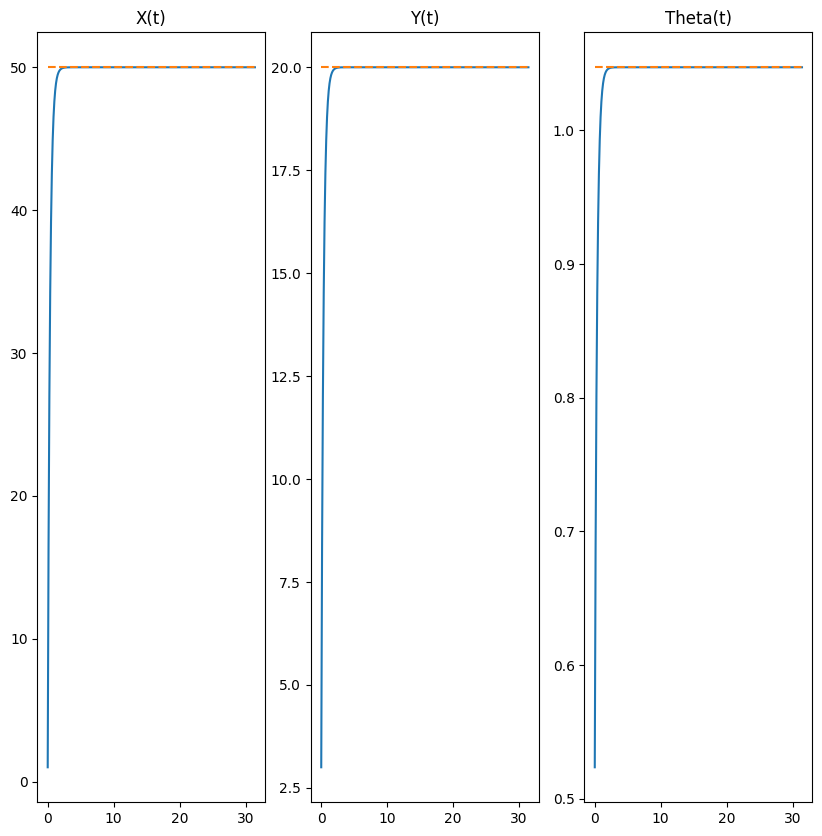

In [44]:
def control_task0(x,t,k):
    """controller to desired states"""
    k1,k2,k3 = k
    u = np.zeros((3,1))
    u[0,0] = -k1 * (x[0,0]-x_d) 
    u[1,0] = -k2 * (x[1,0]-y_d)
    u[2,0] = -k3 * (x[2,0]-th_d)
    u = np.linalg.inv(R_matrix(x[2,0]))@u
    return u

poles = [3,3,3]
state_vec = odeint(system_part1, x0, t, args = (poles,control_task0))
plotter(state_vec,t,constant_trajectory)

##### 1.2)Modify controller to track time varying trajectories, take for instance  𝑥𝑑=10cos𝑡/5,𝑦𝑑=10sin𝑡/5,𝜃𝑑=𝜋/2+𝑡/5

Let us modify controller by the following steps.<br>
Step 1) Define error function:<br>
$$\tilde{x}=x-x_{d}$$
Step 2) Take a derivatives:
$$\frac{d\tilde{x}}{dt}=\frac{dx}{dt}-\frac{dx_{d}}{dt}$$
Step 3) Substitute first guy from initial equation:
$$\frac{d\tilde{x}}{dt}=Ru-\frac{dx_{d}}{dt}$$
Step 4) Derive U:
$$U = R^{-1}*(-Kx + \frac{dx_{d}}{dt})$$

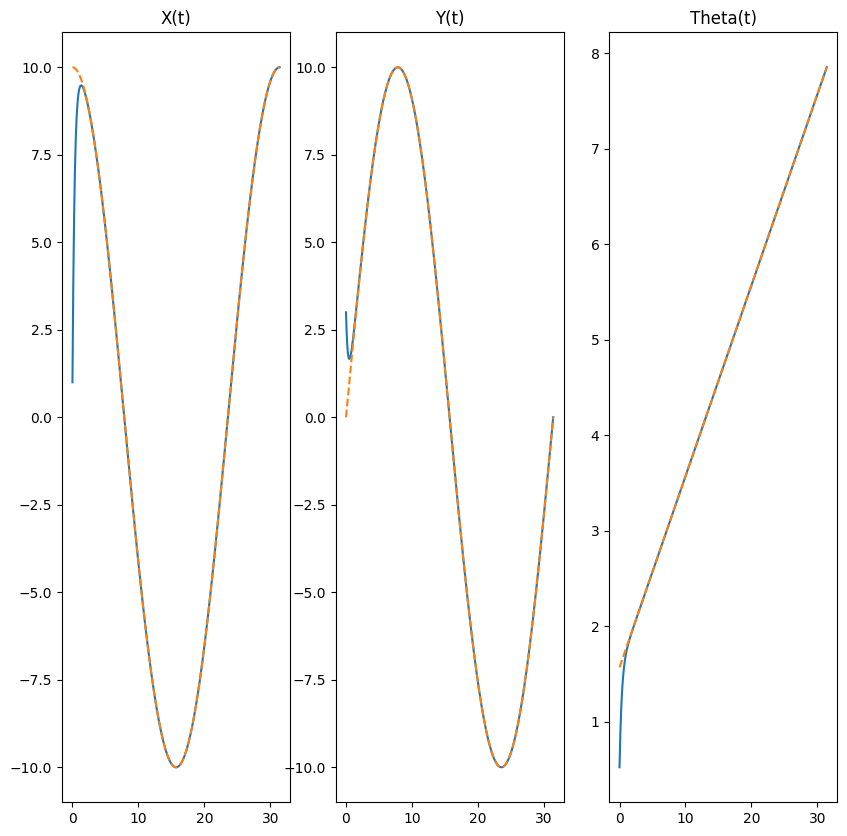

In [45]:
def trajectory(x,t):
    """Desired trajectory"""
    x_traj = 10 * c(t/5)
    y_traj = 10 * s(t/5)
    th_traj = np.pi/2 + t/5
    return x_traj,y_traj,th_traj

def dtrajectory(x,t):
    """Derivatives of desired trajectory"""
    x_traj = -2 * s(t/5)
    y_traj = 2 * c(t/5)
    th_traj = 1/5
    return x_traj,y_traj,th_traj

def control_task1(x,t,k):
    """controller to desired trajectory"""
    k1,k2,k3 = k
    x_traj,y_traj,th_traj = trajectory(x,t)
    u = np.zeros((3,1))
    u[0,0] = -k1 * (x[0,0]-x_traj) - 2*s(t/5)
    u[1,0] = -k2 * (x[1,0]-y_traj) + 2*c(t/5)
    u[2,0] = -k3 * (x[2,0]-th_traj) + 1/5
    u = np.linalg.inv(R_matrix(x[2,0]))@u
    return u

poles = [3,3,3]
state_vec = odeint(system_part1, x0, t, args = (poles,control_task1))

#Used only for plotting
x_ref = [10 * c(t[i]/5) for i in range(len(t))]
y_ref = [10 * s(t[i]/5) for i in range(len(t))]
th_ref = [np.pi/2 + t[i]/5 for i in range(len(t))]
ref_trajectory = [[x_ref],[y_ref],[th_ref]]
plotter(state_vec,t,ref_trajectory)

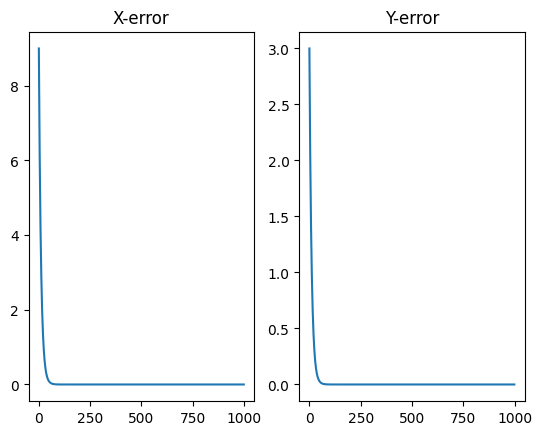

In [46]:
x = state_vec[:,0]
y = state_vec[:,1]

fig,axs = plt.subplots(1,2)
axs[0].plot(np.abs(x-x_ref))
axs[0].set_title("X-error")
# axs[0].set_ylim([0,0.1])
axs[1].plot(np.abs(y-y_ref))
# axs[1].set_ylim([0,0.1])
axs[1].set_title("Y-error")
plt.show()

##### 1.3)Tune the controller such that you will have critically damped response and less controll effort in the  𝑛  direction.

The simplest way to reduce the controller's efforts in the n direction is to change gain k2. Also, for the convergence of the error in the y coordinate, it is necessary that k2 be dependent on it.<br>
Step 1) Suppose that k2 will depend on the error according to the harmonic law:
$$
k_{2} = k_{2}cos(f(\tilde{y}))
$$
Step 2) Let's choose the limits of the function f:
$$
\begin{equation*}
f(\tilde{y}) = 
 \begin{cases}
   0 & \tilde{y}=\infty & and: k_{2}=k_{2}\\
   \frac{\pi}{2} & \tilde{y}=0 & and: k_{2}=0
 \end{cases}
\end{equation*}
$$
Step 3) Suppose the function $k_{2}$:
$$
k_{2} = cos(\frac{\pi}{2}e^{-\tilde{y}})
$$

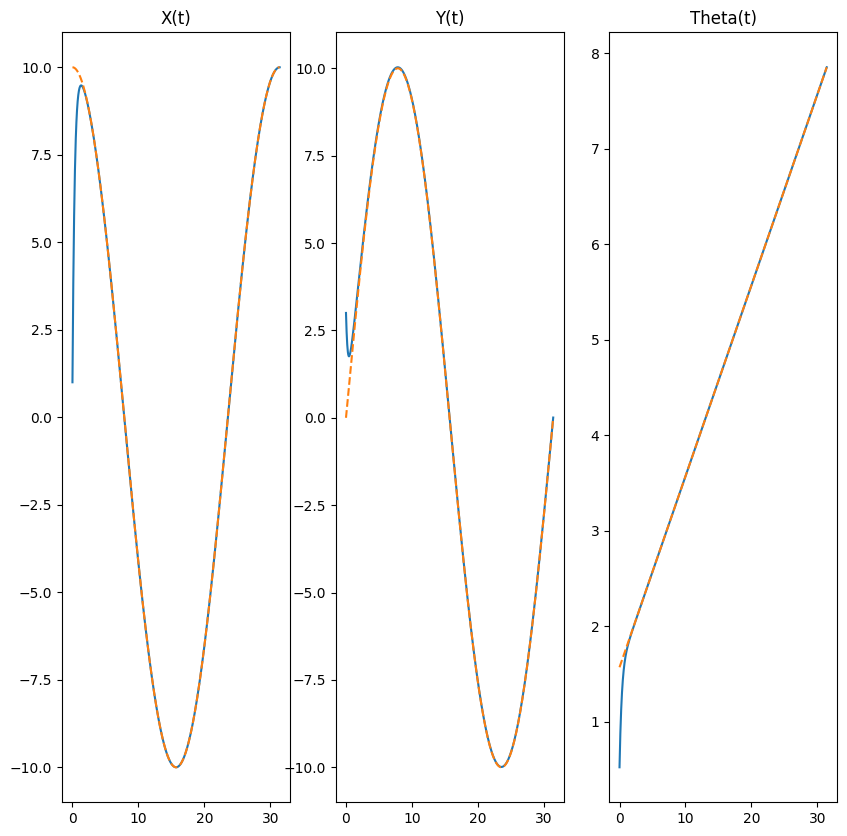

In [47]:
def control_task1_3(x,t,k):
    """controller to desired trajectory"""
    global k2_list
    k1,k2,k3 = k
    x_traj,y_traj,th_traj = trajectory(x,t)
    u = np.zeros((3,1))
    k2 = k2 * c(np.pi/2 * np.exp(-(np.abs(x[1,0]-y_traj))))
    k2_list.append(k2)
    u[0,0] = -k1 * (x[0,0]-x_traj) - 2*s(t/5)
    u[1,0] = -k2 * (x[1,0]-y_traj) + 2*c(t/5)
    u[2,0] = -k3 * (x[2,0]-th_traj) + 1/5
    u = np.linalg.inv(R_matrix(x[2,0]))@u
    return u

k2_list = []
poles = [3,3,3]
state_vec = odeint(system_part1, x0, t, args = (poles,control_task1_3))

#Used only for plotting
plotter(state_vec,t,ref_trajectory)

Let's plot obtained k2 in each iteration:

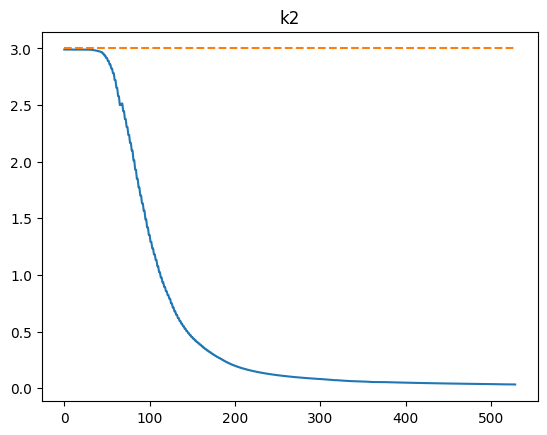

In [48]:
plt.plot(\
         [i for i in range(len(k2_list))],k2_list,
         [i for i in range(len(k2_list))],[poles[1] for i in range(len(k2_list))] , '--'
        )
plt.title("k2")
plt.show()

Also plot the errors:

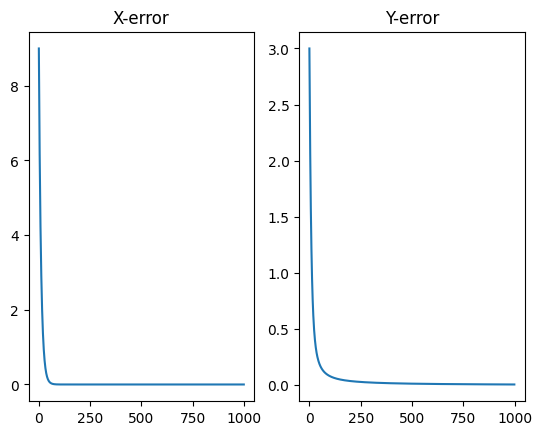

In [49]:
x = state_vec[:,0]
y = state_vec[:,1]

fig,axs = plt.subplots(1,2)
axs[0].plot(np.abs(x-x_ref))
axs[0].set_title("X-error")
# axs[0].set_ylim([0,0.1])
axs[1].plot(np.abs(y-y_ref))
# axs[1].set_ylim([0,0.1])
axs[1].set_title("Y-error")
plt.show()

## Part 2. Flow disturbance and sliding mode:

##### 2.1)Suppose now that there is disturbance due to river flow $\delta < 1$ (as example you may take $\delta(t) = 2/3+\sin(0.1t)/3$, introduce this to the dynamics and study response of inverse dynamics controller.

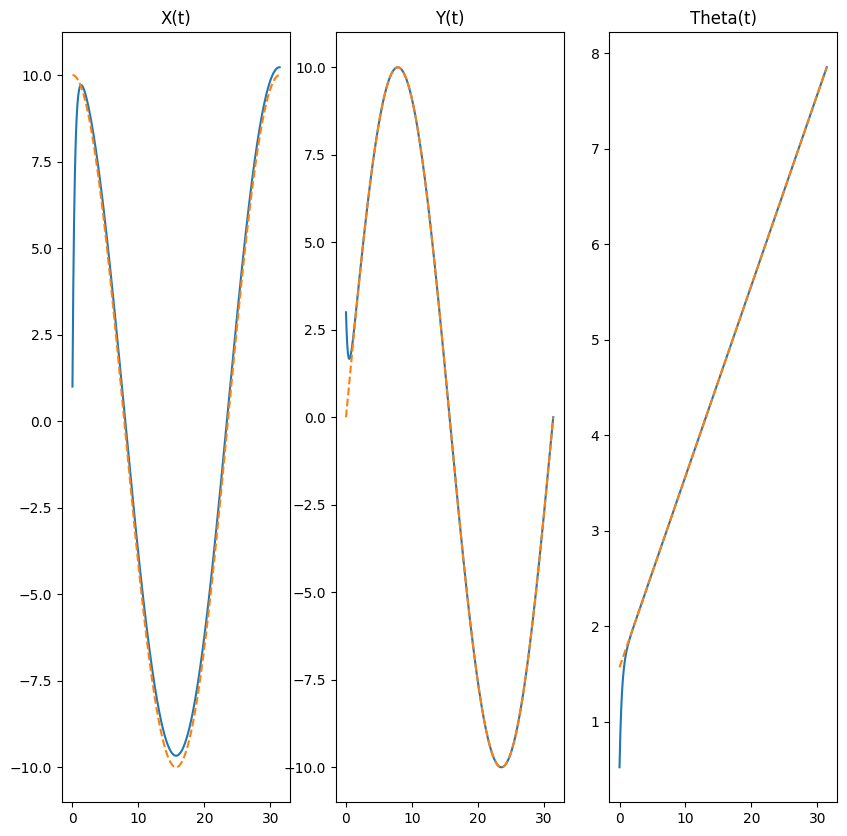

In [50]:
def delta(t):
    """Flow disturbance"""
    delta = np.zeros((3,1))
    delta[0,0] = 2/3 + s(t/10)/3
    return delta

def system_part2(x_vec,t,poles,control_func):
    """
    dx(t)/dt
    """
    #coordinates:
    x,y,th = x_vec
    coord = np.array([[x],[y],[th]])
    #control (velocity vector):
    v = control_func(coord,t,poles)
    #rotation matrix:
    R = R_matrix(th)
    #dx/dt:
    dx_dt = R@v + delta(t)
    System_coordinates = [\
                          dx_dt[0,0],dx_dt[1,0],dx_dt[2,0]
                         ]
                          
    return System_coordinates

def control_task2_1(x,t,k):
    """
    controller to desired trajectory
    Same as in task 1.2. Goal is only to see the difference
    """
    k1,k2,k3 = k
    x_traj,y_traj,th_traj = trajectory(x,t)
    u = np.zeros((3,1))
    u[0,0] = -k1 * (x[0,0]-x_traj) - 2*s(t/5)
    u[1,0] = -k2 * (x[1,0]-y_traj) + 2*c(t/5)
    u[2,0] = -k3 * (x[2,0]-th_traj) + 1/5
    u = np.linalg.inv(R_matrix(x[2,0]))@u
    return u

poles = [3,3,3]
state_vec = odeint(system_part2, x0, t, args = (poles,control_task2_1))

#Used only for plotting
plotter(state_vec,t,ref_trajectory)

**We can see the difference in x-coordinate!**

##### 2.2)Use sliding mode technique to propose the modification of the inverse dynamics controller that will eleminate the effect of the disturbance. Simulate the response.

Initial equation:
$$\frac{dx}{dt}=Ru + \delta(t)$$
Where $u=R^{-1}*V$ and $V$-means the linear part of controller.<br>
So to compensate the disturbance let's add the part responsible for flow compensation $V_{0}$
$$U = V + V_{0}$$
$$\frac{dx}{dt}=Ru+\delta(t)=R*(R^{-1}*(V+V_{0}))+\delta(t)=V+V_{0}+\delta(t)$$
And we can see,that $V_{0}=-\delta(t)$

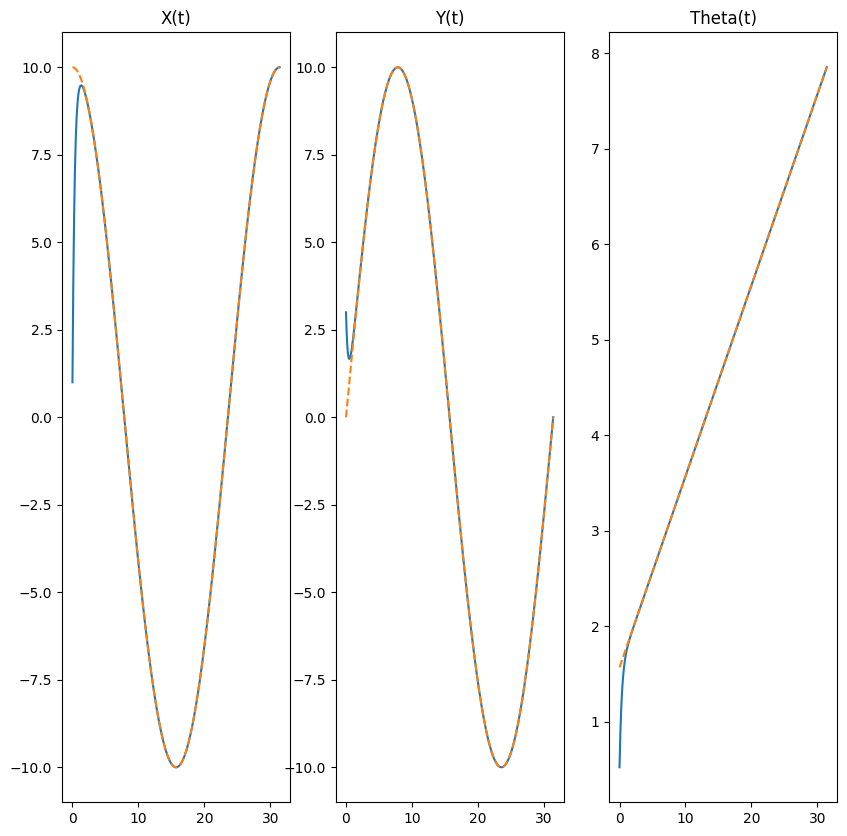

In [51]:
def control_task2_2(x,t,k):
    """
    controller to desired trajectory:
    """
    k1,k2,k3 = k
    x_traj,y_traj,th_traj = trajectory(x,t)
    u = np.zeros((3,1))
   
    u[0,0] = -k1 * (x[0,0]-x_traj) - 2*s(t/5) -( 2/3 + s(t/10)/3)
    u[1,0] = -k2 * (x[1,0]-y_traj) + 2*c(t/5)
    u[2,0] = -k3 * (x[2,0]-th_traj) + 1/5
    u = np.linalg.inv(R_matrix(x[2,0]))@u

    return u

poles = [3,3,3]
state_vec = odeint(system_part2, x0, t, args = (poles,control_task2_2))

#Used only for plotting
plotter(state_vec,t,ref_trajectory)

**We can see, that difference was compensated**

##### 2.3)Tune controller such that convergence to the boundary layer given by  ‖𝐱̃ ‖<0.1  is achieved

Let's use sliding mode technique to achive given boundaries

In [52]:
def control_task2_3(x,t,k):
    """
    sliding mode controller:
    """
    #Trajectory:
    x_traj,y_traj,th_traj = trajectory(x,t)
    #Derivative:
    dx_traj,dy_traj,dth_traj = dtrajectory(x,t)

    #Estimation parameters:
    eta = 0.1 #Boundary
    f_hat = 1 #Magic number №1
    h_hat = 1 #Magic number №2

    #Define u_hat and u_s:
    u_hat,u_s,S = np.zeros((3,1)),np.zeros((3,1)),np.zeros((3,1))

    #S:
    S[0,0] =  x[0,0] - x_traj
    S[1,0] =  x[1,0] - y_traj
    S[2,0] =  x[2,0] - th_traj

    #U_hat:
    u_hat[0,0] =  (dx_traj - f_hat) / h_hat
    u_hat[1,0] =  (dy_traj - f_hat) / h_hat
    u_hat[2,0] =  (dth_traj - f_hat) / h_hat

    #U_s:
    for i in range(3):
      if abs(S[i,0]) > eta:
        sgn = np.sign(S[i,0])
        u_s[i,0] = -k[0]*sgn/eta/h_hat
      else:
        u_s[i,0] = -k[0]*S[i,0]/eta/h_hat

    u = np.linalg.inv(R_matrix(x[2,0]))@(u_hat+u_s)
    # u = np.linalg.inv(R_matrix(x[2,0]))@u
    print(u_hat.shape, u_s.shape)

    return u

(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1) (3, 1)
(3, 1)

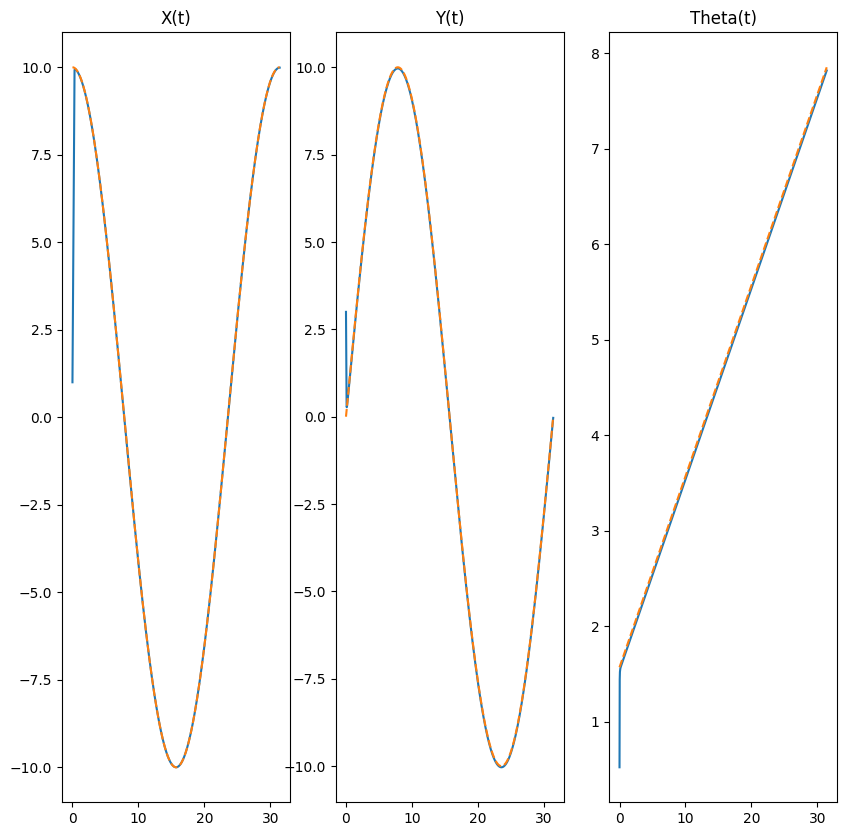

In [53]:
poles = [3,3,3]
state_vec = odeint(system_part2, x0, t, args = (poles,control_task2_3))

#Used only for plotting
plotter(state_vec,t,ref_trajectory)

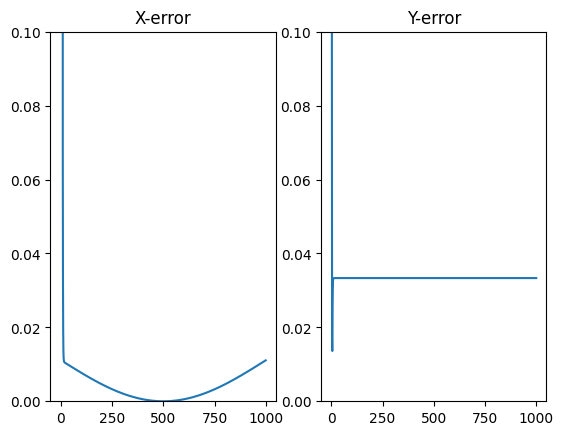

In [54]:
x = state_vec[:,0]
y = state_vec[:,1]

fig,axs = plt.subplots(1,2)
axs[0].plot(np.abs(x-x_ref))
axs[0].set_title("X-error")
axs[0].set_ylim([0,0.1])
axs[1].plot(np.abs(y-y_ref))
axs[1].set_title("Y-error")
axs[1].set_ylim([0,0.1])
plt.show()

## Part 3. Adaptive control:

##### 3.1)Assume now that bounds on the river flow is not known in advance, propose the adaptive control that will estimate the unknown disturbance while tracking the same trajectories

We can see that there is no **x** dependence in disturbance. So we can introduce one parameter to estimate $a_{estimated}$

In [55]:
def phi(t):
    """Phi(x)"""
    return np.array([1])

#Initial parameters a and b: 
a0 = 1/6
gamma = 0.5

#Controller:
def control_task3_1(x,t,k,p_hat):
    """
    controller to desired trajectory:
    """
    k1,k2,k3 = k
    x_traj,y_traj,th_traj = trajectory(x,t)
    u = np.zeros((3,1))
    
    adaptive_estimation = phi(t)@np.array([[p_hat[0][0]]])
    u[0,0] = -k1 * (x[0,0]-x_traj) - 2*s(t/5) - adaptive_estimation[0]
    u[1,0] = -k2 * (x[1,0]-y_traj) + 2*c(t/5)
    u[2,0] = -k3 * (x[2,0]-th_traj) + 1/5
    u = np.linalg.inv(R_matrix(x[2,0]))@u
    
    # adaptation law
    x_e = x_traj - x[0,0]
    dp_hat =  -phi(t).T * x_e/gamma
    return u , dp_hat

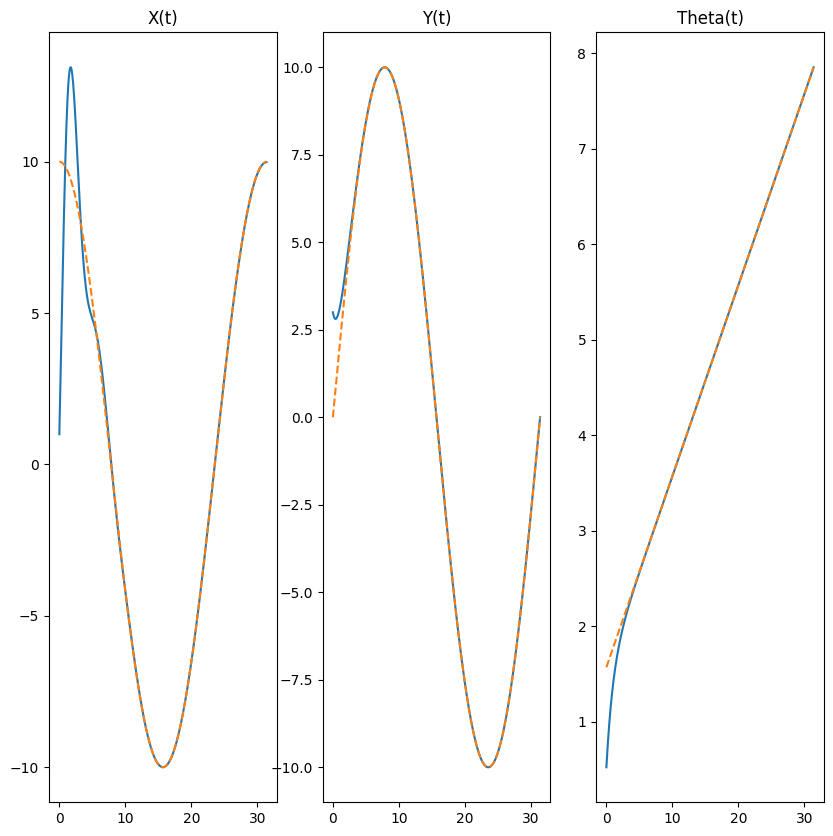

In [56]:
def system_part3(x_vec,t,poles,control_func):
    """
    dx(t)/dt
    """
    #coordinates:
    x,y,th = x_vec[0:3]
    coord = np.array([[x],[y],[th]])

    #parameters for adaptive control:
    p_hat = np.array([[x_vec[3]]])
    
    #control (velocity vector):
    v,dp_hat = control_func(coord,t,poles,p_hat)
    
    #rotation matrix:
    R = R_matrix(th)
    #dx/dt:
    dx_dt = R@v + delta(t)
    System_coordinates = [\
                          dx_dt[0,0],dx_dt[1,0],dx_dt[2,0],
                          dp_hat[0]
                         ]
                          
    return System_coordinates

poles = [1,1,1]
init_vec = np.append(x0,[a0])

state_vec = odeint(system_part3, init_vec, t, args = (poles,control_task3_1))

#Used only for plotting
plotter(state_vec,t,ref_trajectory)

Plot parameters evolution

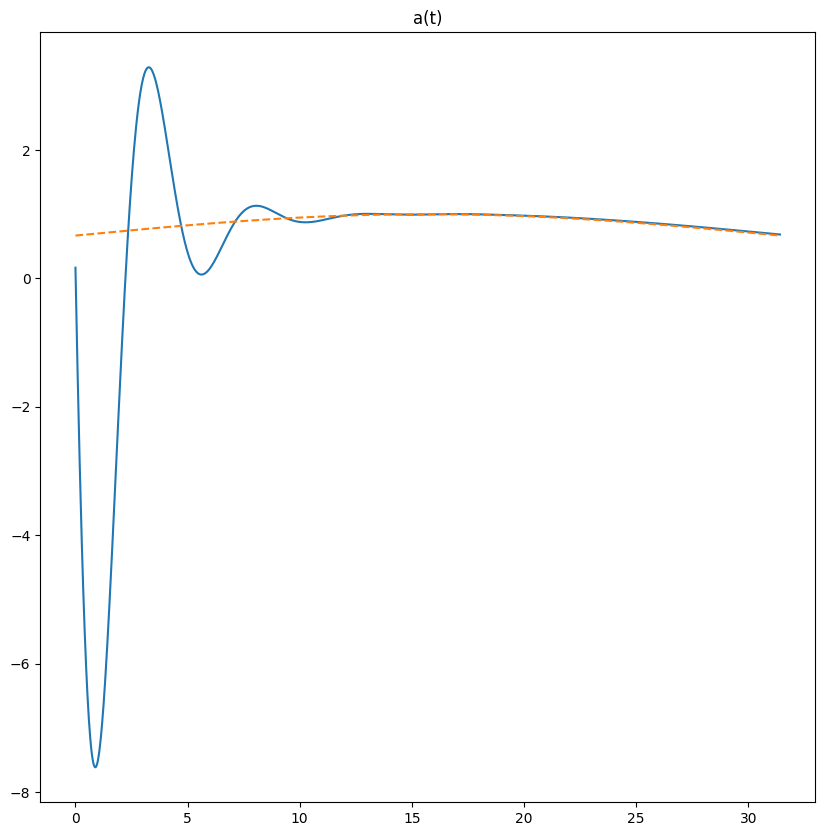

In [57]:
"""Plot solutions"""
a_est = state_vec[:,3]

fig,axs = plt.subplots(1,1, figsize=(10, 10))
axs.plot(t,a_est, t, [2/3 + 1/3*s(0.1*t[i]) for i in range(len(t))],'--')
axs.set_title("a(t)")
plt.show()

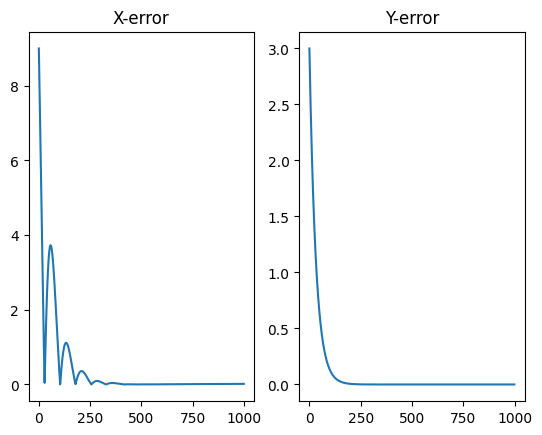

In [58]:
x = state_vec[:,0]
y = state_vec[:,1]

fig,axs = plt.subplots(1,2)
axs[0].plot(np.abs(x-x_ref))
axs[0].set_title("X-error")
axs[1].plot(np.abs(y-y_ref))
axs[1].set_title("Y-error")
plt.show()

**[BONUS]** Overactuated vessel and Input mapping

In practice the actual inputs are not the linear and angular velocities of the cessel. For instance consider the case of four thrusters installed on the vessel such that the mapping between thrusters and vessel velocity is given by:
$$
\mathbf{u} =
\begin{bmatrix}
v_\tau
\\
v_n
\\
\omega
\end{bmatrix}
=
\begin{bmatrix}
 -\cos \phi & -\cos \phi & 1 & 1\\
 \sin \phi & \sin \phi & 0 & 0\\
 -\ell_2\cos \phi  + \ell_1\sin \phi &  \ell_2\cos \phi  - \ell_1\sin \phi & -\ell & \ell\\
\end{bmatrix}
\begin{bmatrix}
v_1
\\
v_2
\\
v_3
\\
v_4
\end{bmatrix} 
= \mathbf{H}(\phi)\mathbf{u}^*
$$

* Modify system dynamics, and either adaptive or robust controller and find appropriate $\mathbf{u}^*$ such that boat will have the same response as if you control $\mathbf{u}$ directly.
* Assume now that the $v_1, v_2$ are twice less powerfull then $v_3, v_4$. How would you modify your controller to tackle this 
* Introduce the trajectory planner to your controller such that vessel will favour the velocity along the $\tau$ direction. (read notes below)
 


**[NOTES] Feasible trajectory via differential flatness**

In many mobile robots including the vessels we do favour the motion that are directed along the $\tau$ component of robot, while the $n$ component remain zero or small. However the resulting trajectory should still be still feasible for our robot. 

Let us set $v_n = 0$, thus arriving to following expression:
$$
\dot{\mathbf{x}} =
\begin{bmatrix}
\dot{x}
\\
\dot{y}
\\
\dot{\theta}
\end{bmatrix}
=
\begin{bmatrix}
 v_\tau \cos \theta  \\
 v_\tau \sin \theta \\
 \omega\\
\end{bmatrix}
$$
Here we neglects the disturbance effects.

Assume that we have desired position in task space $x(t)$, $y(t)$, the question is can we calculate the reminding $\theta,v,\omega$ as a function of $x,y$ and it's derivatives. 
First we take the squares of first and second terms yields:

$$
v_\tau = \eta\sqrt{\dot{x}^2 + \dot{y}^2} 
$$
here $\eta$ is 
the division of the first and second yields:

$$
\theta =\operatorname {atan2} (\eta \dot{y}, \eta \dot{x})
$$

Taking the derivatives of first and second equation after a bit of algebra yields: 
$$
\omega = \eta\frac{\dot{x}\ddot{y}-\dot{y}\ddot{x}}{v_\tau^2}
$$

Not how the all signals are given as **algebraic functions** of $x, y, \dot{x}, \dot{y}, \ddot{x}, \ddot{y}$. Thus once the desired trajectory is given for the $x, y$, one can automatically recover the open loop controller $\omega, v$ and remaining state $\theta$, this property is known as differential flatness and grately simplify the trajectory planning.